In [ ]:
# Install PyTorch and Matplotlib
%pip install torch torchvision
%pip install matplotlib

In [15]:
# Imports 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

In [16]:
# Data Paths
train_data_dir = '../data/pepsico_dataset/Train/'
test_data_dir = '../data/pepsico_dataset/Test/'

In [17]:
batch_size = 32
image_size = (250, 250)

In [18]:
# Transformations (Preprocessing images)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

In [19]:
# Creating train/test datasets and loaders
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
# Convolutional neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * (image_size[0] // 8) * (image_size[1] // 8), 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x
    
model = Net()

In [21]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=123008, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [22]:
# Checkpoint filepath
checkpoint_filepath = r'C:/Users/deepk/OneDrive/Documents/College/6th Year/CSCE 580/CSCE580-Fall2023-DeepPatel-Repo/code/pytorch_checkpoint.pt'

In [23]:
# Setup checkpoint
checkpoint_model = Net()
checkpoint = torch.load(checkpoint_filepath)
checkpoint_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
num_epochs = checkpoint['epoch']

In [24]:
# Model evaluation variables
checkpoint_model.eval()
total_val = 0
correct_val = 0

In [25]:
# Model training and evaluation
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train = 0
    correct_train = 0
    train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels.float().view(-1, 1)).sum().item()
        train_loss += loss.item()

    training_accuracy.append(correct_train / total_train)
    training_loss.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    total_val = 0
    correct_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels.float().view(-1, 1)).sum().item()
            val_loss += criterion(outputs, labels.float().view(-1, 1)).item()

    validation_accuracy.append(correct_val / total_val)
    validation_loss.append(val_loss / len(test_loader))


In [26]:
# Print accuracy
print(f"Test Accuracy: {validation_accuracy[-1]}")

Test Accuracy: 0.984375


In [ ]:
# Save model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, checkpoint_filepath)

In [27]:
# Loading model checkpoint (includes evaluation and printing)
if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_filepath)
else:
    # Load on CPU
    checkpoint = torch.load(checkpoint_filepath, map_location=torch.device('cpu'))

# Create model and load state dict
checkpoint_model = Net()
checkpoint_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
num_epochs_checkpoint = checkpoint['epoch']

# Model evaluation on the test dataset
checkpoint_model.eval()
total_val = 0
correct_val = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = checkpoint_model(inputs)
        predicted = torch.round(outputs)
        total_val += labels.size(0)
        correct_val += (predicted == labels.float().view(-1, 1)).sum().item()

# Print accuracy
accuracy = correct_val / total_val
print(f"Accuracy: {accuracy}")

Accuracy from Checkpoint: 0.5208333333333334


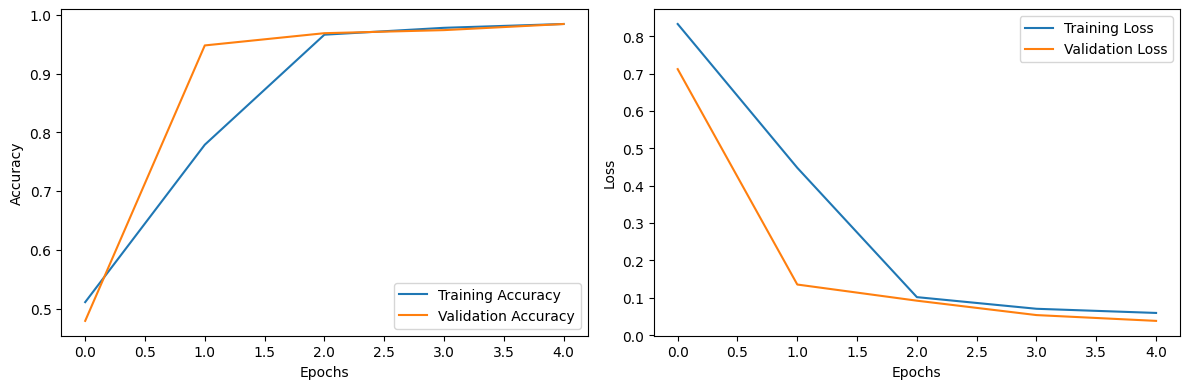

In [28]:
# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), training_accuracy, label='Training Accuracy')
plt.plot(range(num_epochs), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), training_loss, label='Training Loss')
plt.plot(range(num_epochs), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()